# Gradient Boosting
## Import Libraries

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from Utils import plot_corrlation_heatmap, plot_mi_heatmap
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, export_final_selected_features_to_csv

## Import Train and Test Datasets

In [3]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [4]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Version": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Version": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In this notebook, we will explore Gradient Boosting. It builds a strong predictive model by combining an ensemble of weak learners, typically decision trees. It works by iteratively fitting new models to the residual errors of the previous models, with each subsequent model focusing on the areas where the previous ones performed poorly.

The model will first be trained with all available features on the default setting, then apply feature selection method to select the optimal set of features, and perform hyperparameter tuning. The performance of the model in each stage will be observed and compared.

For Boosting models, there are 2 common ways for feature selection:
1. In-built Feature Importance Score: Boosting algorithms compute feature importance scores during the training process. Feature importance scores are typically based on metrics such as the total reduction in impurity (e.g., Gini impurity or entropy) achieved by splitting on a particular feature across all decision trees in the ensemble. These scores reflect the contribution of each feature to the overall performance of the model.
2. Permutation Importance: It assesses the importance of each feature by measuring how much the model's performance deteriorates when the values of that feature are randomly shuffled (permuted). The drop in performance after permutation reflects the importance of the feature: a larger drop indicates a more important feature, while a smaller drop suggests a less important feature. Permutation importance provides a more robust assessment of feature importance compared to feature importance scores, as it directly measures the impact of each feature on the model's performance.

Compared to Recursive Feature Elimination, in-built feature selection methods like feature importance scores and permutation importance are generally preferred in the context of boosting algorithms, as they offer a more comprehensive and efficient approach to feature selection based on the model's behavior and performance.

In [5]:
# Set up a dataframe to store the results from different versions
train_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Build the Baseline Model before Feature Engineering

In [6]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [7]:
X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [316]:
gb_basic = GradientBoostingClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [317]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = gb_basic.predict(X_train_basic)
Y_test_pred_basic = gb_basic.predict(X_test_basic)

In [318]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8393978030600235
Precision 	: 0.8492984758251741
Recall 		: 0.8252255786582974
F1 Score 	: 0.8370889916927823

**Test Set Metrics**
Accuracy 	: 0.8337818003913894
Precision 	: 0.6415425065731815
Recall 		: 0.4351961950059453
F1 Score 	: 0.5185972369819342


## Build the Baseline Model after Feature Engineering

In [8]:
gb = GradientBoostingClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [9]:
# Predict the output based on our training and testing dataset
Y_train_pred = gb.predict(X_train)
Y_test_pred = gb.predict(X_test)

In [321]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8478815221655551
Precision 	: 0.8548419367747099
Recall 		: 0.8380737544134955
F1 Score 	: 0.8463748019017432

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5900490539593553
Recall 		: 0.5005945303210464
F1 Score 	: 0.5416532647153426


## Eliminate the Features with permutation_importance=0

In [10]:
feature_importances, feature_names = compute_permutation_importance(gb, X_train, Y_train)

In [11]:
# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

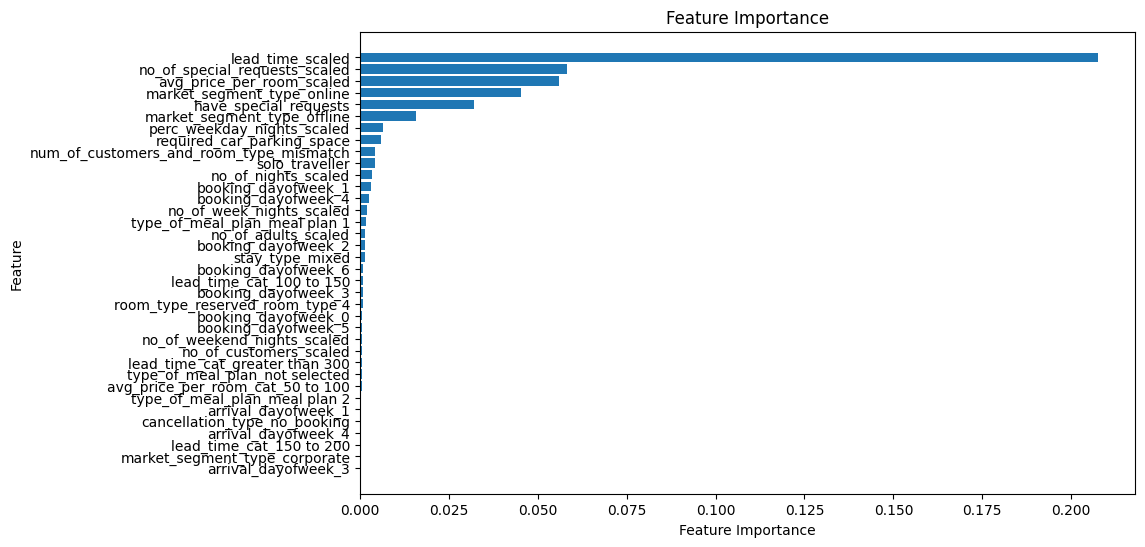

In [12]:
# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [13]:
selected_columns = feature_names

## Fit the Model again with the selected set of features

In [14]:
gb_selected = GradientBoostingClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [15]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = gb_selected.predict(X_train[selected_columns])
Y_test_pred_selected = gb_selected.predict(X_test[selected_columns])

In [328]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8471949784229109
Precision 	: 0.853505092869982
Recall 		: 0.8382699097685367
F1 Score 	: 0.845818901533894

**Test Set Metrics**
Accuracy 	: 0.8261986301369864
Precision 	: 0.5914505956552207
Recall 		: 0.5017835909631391
F1 Score 	: 0.5429398520424574


## Eliminate Features with low in-built feature importance

In [16]:
# Get feature importance score
feature_importances = gb_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Remove features with feature_importances<=0.001
feature_names = feature_names[feature_importances>0.001]
feature_importances = feature_importances[feature_importances>0.001]

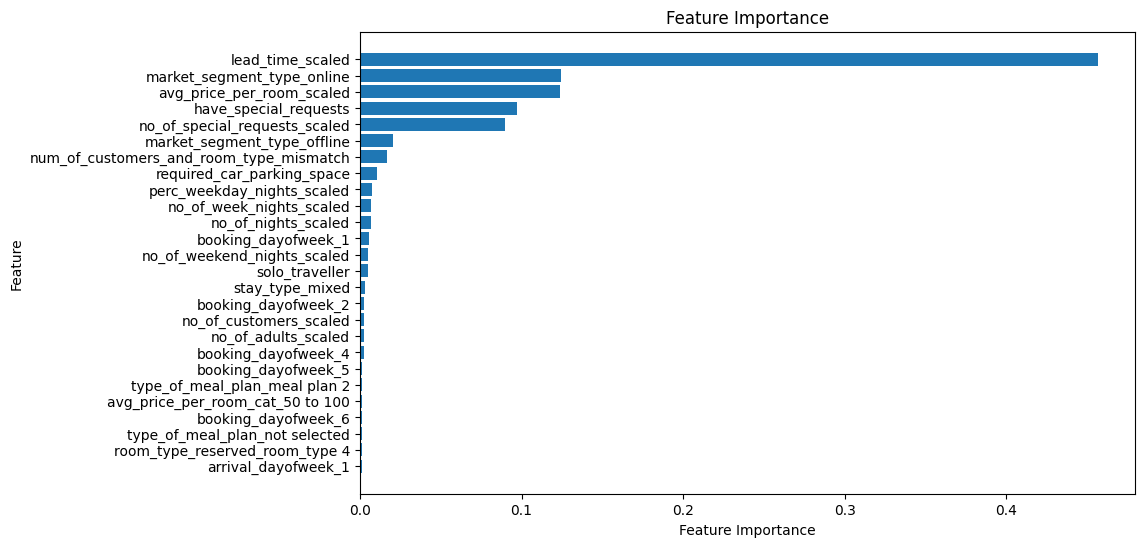

In [17]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

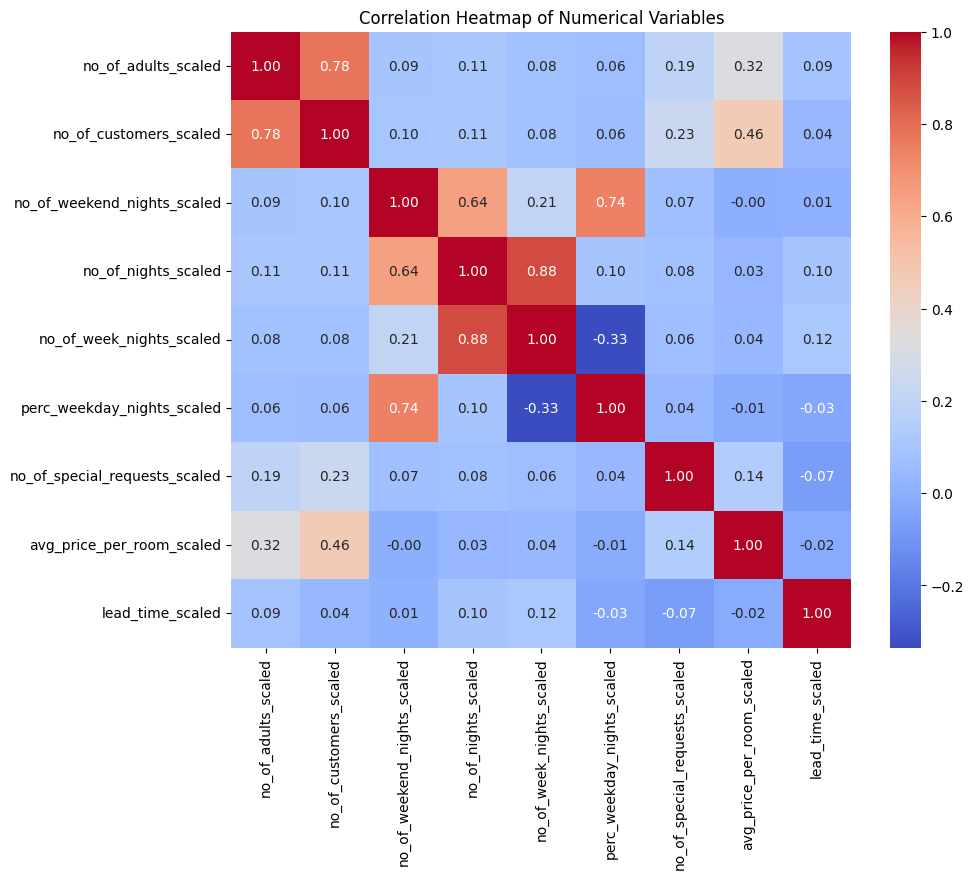

In [331]:
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
plot_corrlation_heatmap(X_train[num_cols])

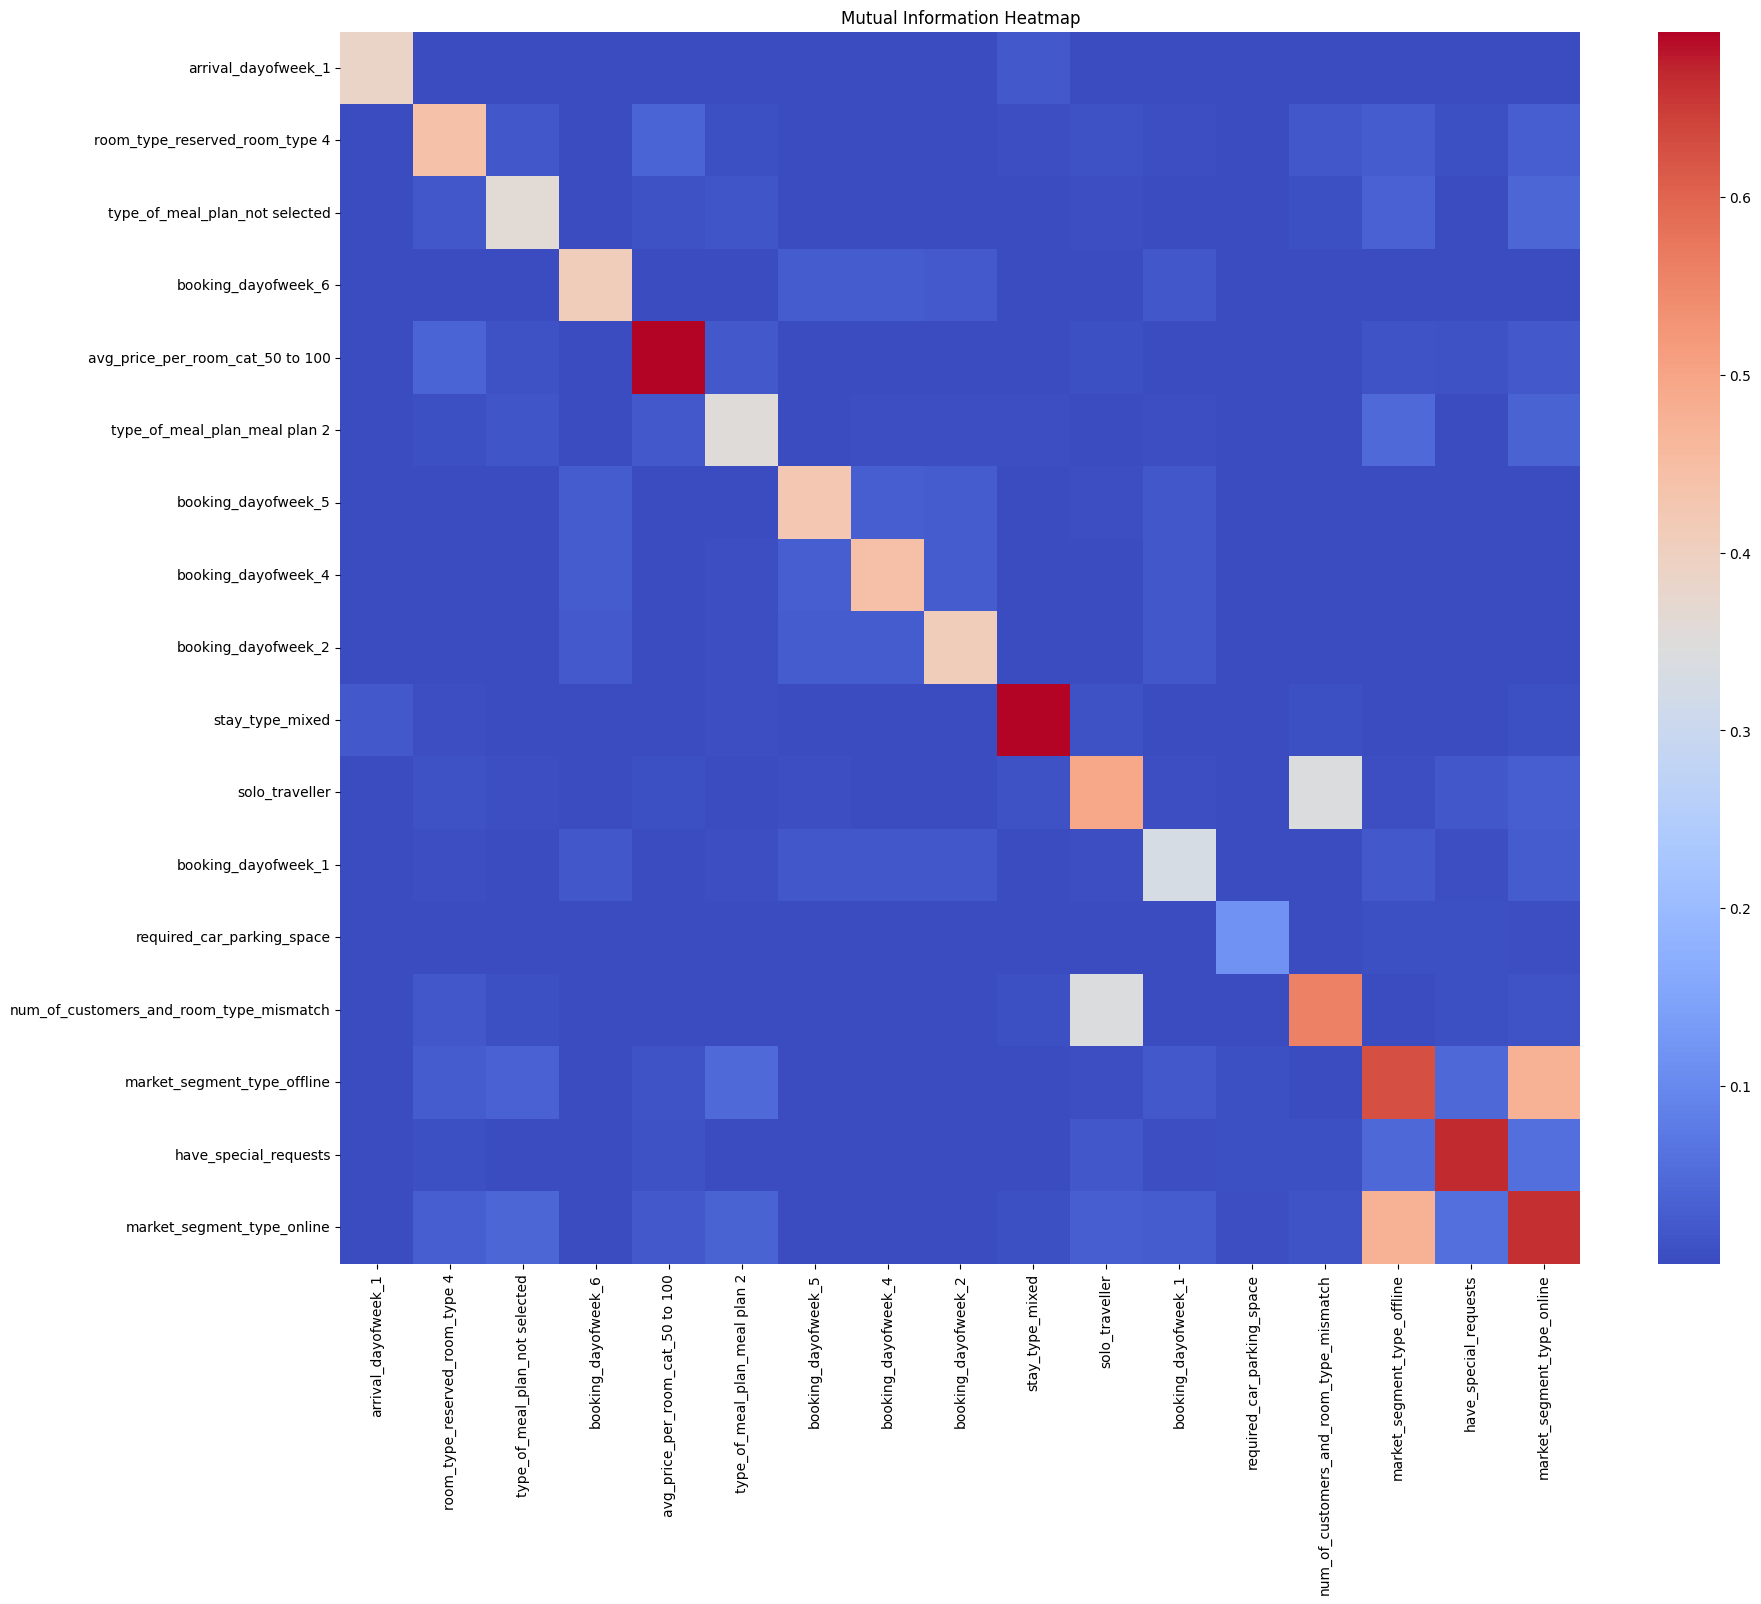

In [332]:
cat_cols = [x for x in feature_names[sorted_indices] if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled', 'no_of_weekend_nights_scaled', 'num_of_customers_scaled', 'solo_traveller', 'market_segment_type_offline' will be removed.

In [18]:
to_remove = ['no_of_nights_scaled', 'no_of_weekend_nights_scaled', 'num_of_customers_scaled', 'solo_traveller', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

## Fit the model with the final set of features

In [334]:
gb_selected_final = GradientBoostingClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [335]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = gb_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = gb_selected_final.predict(X_test[final_columns])

In [336]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8457728520988623
Precision 	: 0.858027825733726
Recall 		: 0.8286582973715182
F1 Score 	: 0.8430873621713316

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5894224077940153
Recall 		: 0.5035671819262783
F1 Score 	: 0.5431227957678744


## Hyperparameter Tuning

For GradientBoostingClassifier, there are several hyperparameters to tune:
1. n_estimators (default=100): The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
2. learning_rate (default=0.1): Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
3. max_depth (default=3): Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
4. min_samples_split (default=2): The minimum number of samples required to split an internal node.
5. min_samples_leaf (default=1): The minimum number of samples required to be at a leaf node.
6. subsample (default=1.0): The fraction of samples to be used for fitting the individual base learners.
7. max_features (default=None): The number of features to consider when looking for the best split.

### Tuning n_estimators

In [749]:
parameters_n_estimators = {
    'n_estimators': range(50, 300, 50),
    }
model = GradientBoostingClassifier(random_state=47)
grid_search_n_estimators = GridSearchCV(model, param_grid=parameters_n_estimators, cv=5, scoring='f1', verbose=1)
grid_search_n_estimators.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=47),
             param_grid={'n_estimators': range(50, 300, 50)}, scoring='f1',
             verbose=1)

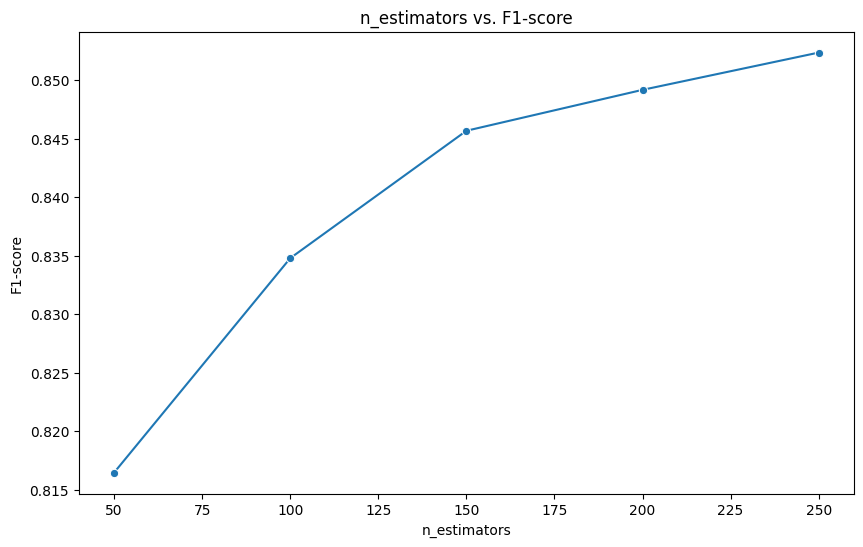

In [338]:
plt.figure(figsize=(10, 6))

# Plotting n_estimators vs. f1
sns.lineplot(x=list(range(50, 300, 50)), y=grid_search_n_estimators.cv_results_['mean_test_score'], marker='o')
plt.title('n_estimators vs. F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score')
plt.show()

More obvious improvement can been seen when n_estimators increases from 50 to 150, but after that the improvement is more subtle. Therefore, we will adopt n_estimators=150 for the following tuning.

### Tune learning_rate

In [750]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
model = GradientBoostingClassifier(n_estimators=150, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2]}, scoring='f1',
             verbose=1)

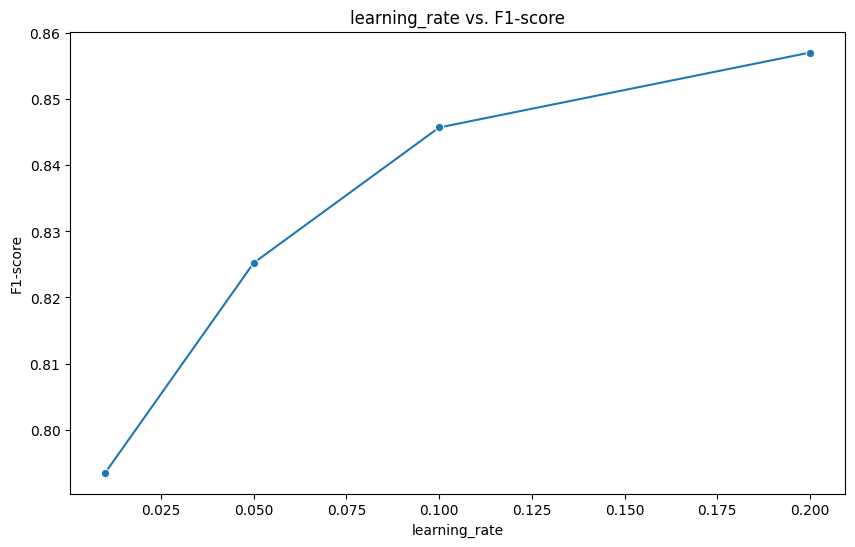

In [340]:
plt.figure(figsize=(10, 6))

# Plotting learning rate vs. f1
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

learning_rate = 0.1 remains as the optimal solution, as after that the improvement is much slower.

### Tune max_depth, min_samples_split, and min_samples_leaf

In [751]:
parameters_tree = {
    'max_depth':range(2,5,1), 
    'min_samples_split':[2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10]
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=47)
grid_search_tree = GridSearchCV(model, param_grid=parameters_tree, cv=5, scoring='f1', verbose=1)
grid_search_tree.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 5),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=1)

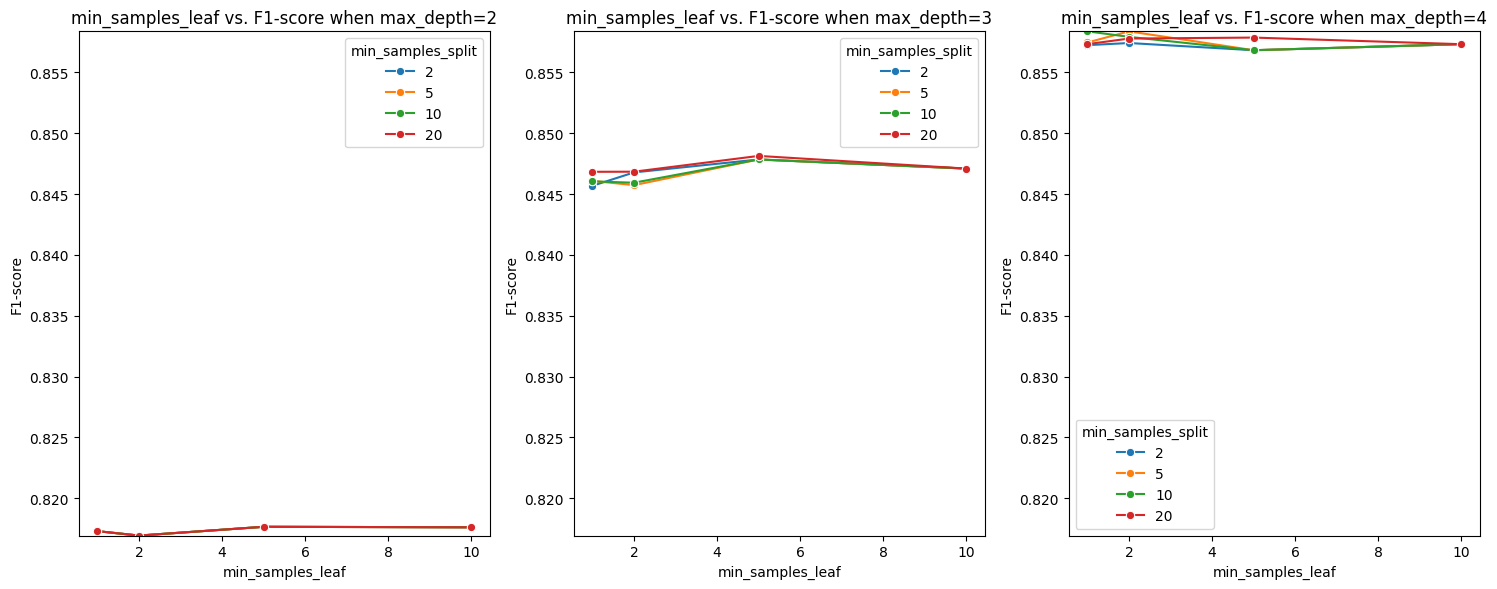

In [342]:
plt.figure(figsize=(15, 6))

# Plotting max_depth, min_samples_leaf, min_samples_split vs. f1
for i in range(3):
    plt.subplot(1, 3, i+1)
    for j in range(4):
        sns.lineplot(x=[1, 2, 5, 10], y=grid_search_tree.cv_results_['mean_test_score'][list(range(j+i*16, 16+i*16, 4))], marker='o', label=f'{[2, 5, 10, 20][j]}')
    plt.title(f'min_samples_leaf vs. F1-score when max_depth={[2,3,4][i]}')
    plt.ylim(min(grid_search_tree.cv_results_['mean_test_score']), max(grid_search_tree.cv_results_['mean_test_score']))
    plt.xlabel('min_samples_leaf')
    plt.ylabel('F1-score')
    plt.legend(title="min_samples_split") 
    plt.tight_layout()
plt.show()

The performance difference introcuded by min_samples_leaf and min_samples_split seems very subtle, so we will keep their default settings, i.e. min_samples_leaf=1 and min_samples_split=2. Subsequently, we want to tune max_depth alone to reveal clearer pattern.

### Tune max_depth alone

In [752]:
parameters_max_depth = {
    'max_depth':range(2,8,1)
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 8)}, scoring='f1', verbose=1)

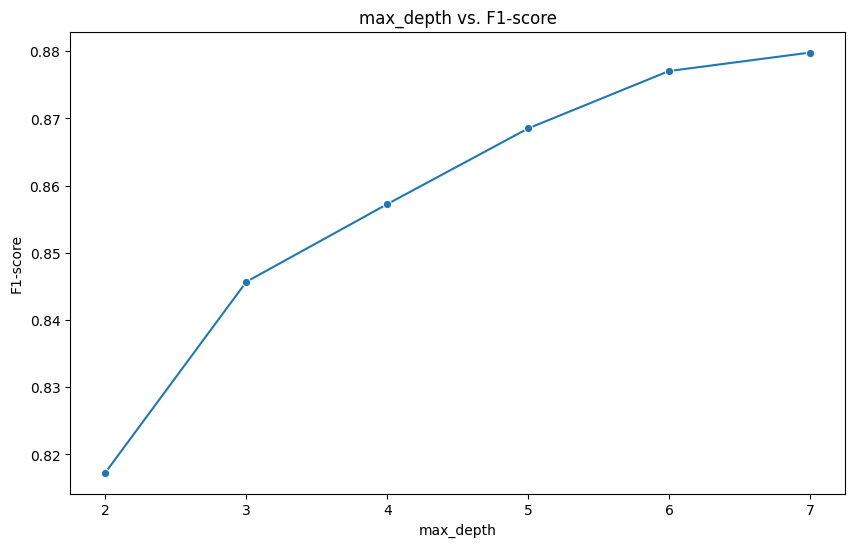

In [344]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=range(2,8,1), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

The results show that model performance keeps improving as max_depth increases. However, this may be because the model overfit to the training data. To avoid such situations from happening, we opt for a smaller max_depth and keep the default setting: max_depth=6.

### Tune subsample and max_features

In [753]:
parameters_subsample = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [0.6, 0.8, 1]
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, max_depth=6, random_state=47)
grid_search_subsample = GridSearchCV(model, param_grid=parameters_subsample, cv=5, scoring='f1', verbose=1)
grid_search_subsample.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=6, n_estimators=30,
                                                  random_state=47),
             param_grid={'max_features': [0.6, 0.8, 1],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=1)

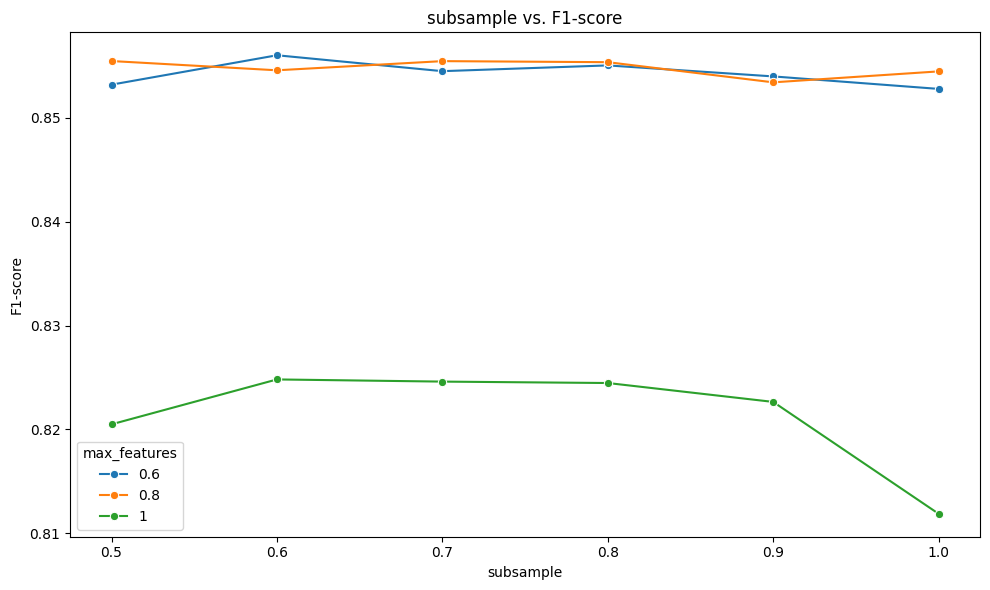

In [346]:
plt.figure(figsize=(10, 6))

# Plotting subsample, max_feature vs. f1
for i in range(3):
    sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_subsample.cv_results_['mean_test_score'][list(range(i*6, 6+i*6, 1))], marker='o', label=f"{['0.6', '0.8', '1'][i]}")
plt.title(f'subsample vs. F1-score')
plt.xlabel('subsample')
plt.ylabel('F1-score')
plt.legend(title="max_features") 
plt.tight_layout()
plt.show()

When max_feature=0.8 and subsample=0.6, it provides the optimal performance, so we will adopt that.

## Fit the Model again the tuned hyperparameters

In [20]:
gb_tuned = GradientBoostingClassifier(n_estimators=150, max_depth=6, max_features=0.8, subsample=0.6, random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [348]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = gb_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = gb_tuned.predict(X_test[final_columns])

In [349]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.910847391133778
Precision 	: 0.923216811477066
Recall 		: 0.896233817183209
F1 Score 	: 0.9095252314123617

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5866486850977748
Recall 		: 0.5172413793103449
F1 Score 	: 0.5497630331753556


## Evaluation

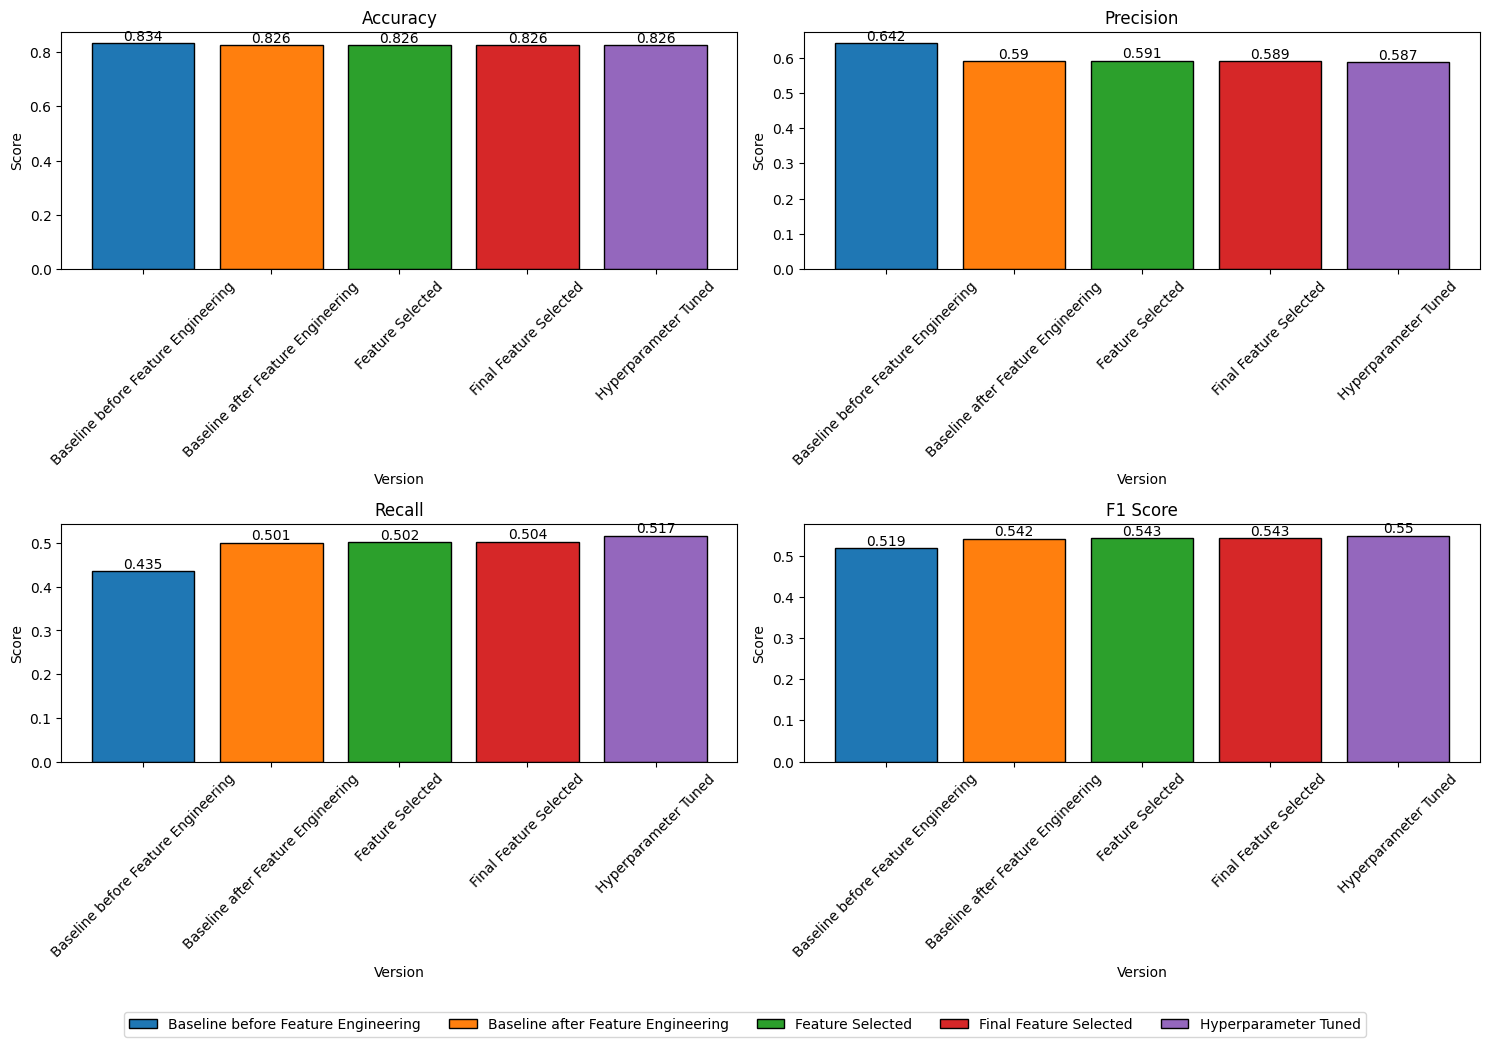

In [350]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

colormap = plt.cm.get_cmap('tab10')

for i, data in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    colors = colormap.colors[:len(test_metrics['Version'])]
    for index, (model, value) in enumerate(zip(test_metrics['Version'], test_metrics[data])):
        axs[i].bar(model, value, color=colors[index], label=model if i == 0 else "", edgecolor='k')
    axs[i].set_title(data)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Version')
    axs[i].set_xticks(test_metrics['Version'])
    axs[i].set_xticklabels(test_metrics['Version'], rotation=45)
    for index, value in enumerate(test_metrics[data]):
        axs[i].text(index, value, str(round(value, 3)), ha='center', va='bottom')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=len(test_metrics['Version']))

plt.tight_layout()
plt.show()

## Export

In [19]:
# export the features used for this model
export_final_selected_features_to_csv(final_columns, "Best Gradient Boosting")


Features exported successfully to FinalModels/Feature_Selection/Best Gradient Boosting


In [21]:
# export the best model to be compared later on
joblib.dump(gb_tuned, "FinalModels/BestGradientBoosting.pkl")

['FinalModels/BestGradientBoosting.pkl']